# Krista, working on linking CO and KO
#from HA species...2/10/2016 

In [3]:
import pandas as pd
import urllib2
from bs4 import BeautifulSoup
import re
from sklearn.cluster import KMeans
import palettable as pal
from itertools import chain
import os
import os.path #? not sure if I need both
import glob
import numpy as np
from IPython.core.debugger import Tracer #used this to step into the function and debug it, also need line with Tracer()() 

import matplotlib.pyplot as plt
import matplotlib as mpl #KL moved this here 2/12/2016
#BUT...then messes with the plotting
mpl.rcParams['pdf.fonttype'] = 42
%matplotlib inline
from collections import Counter
import cPickle as cpk

from stackedBarGraph import StackedBarGrapher
SBG = StackedBarGrapher()



Also, will need to export the following from MATLAB
(1) RInumber, (2) CO number, (3) ion mode information

The KEGG CO numbers from the RI data are not unique. In MATLAB, I have created a new value 'RInumber' which is an arbitrary number for each 'mzRT' feature. The data exported out of MATLAB include that number, the corresponding KEGG CO number, and whether the feature was observed in positive or negative ion mode. These data will be uesd to create a lookup table which allow use of the CO numbers or RInumbers as needed.

In [4]:
mtabFile = 'RImetabolites_isomers.2015.08.27.csv' #first column is RInumber

In [5]:
CO_fromMATLAB=pd.read_csv(mtabFile, index_col='RInumber')
# CO_fromMATLAB=CO_RawData[CO_RawData.sum(axis=1)!=0]
#read in the data from MATLAB and take a quick look
CO_fromMATLAB.head(n=5)

,cNumber,ChargedMass,RT,ionMode,S1,S2,S3,S4,S5
RInumber,,,,,,,,,
RI1,C06593,114.091340,420.6627,positive,0.005583,0.005715,0.006027,0.002645,0.003441
RI2,C01585,117.091006,343.2985,positive,0.000305,0.000486,0.000613,0.000389,0.000436
RI3,C02948,117.091006,343.2985,positive,0.000305,0.000486,0.000613,0.000389,0.000436
RI4,C03739,117.091006,343.2985,positive,0.000305,0.000486,0.000613,0.000389,0.000436
RI5,C12293,117.091006,343.2985,positive,0.000305,0.000486,0.000613,0.000389,0.000436


make the list of unique cNumbers here, do the KEGG thing and filter the list before I start splitting up the dataframes into data and metadata...

In [6]:
#make a list of the unique CO numbers for the CreateHash_COtoKO.py. Export the list as CSV
td = CO_fromMATLAB.groupby('cNumber').count()
COnumbers = td.drop(list(td.columns.values),axis=1)
del td
COnumbers.to_csv('exportCOnumbers.csv',header=True)

###Write a couple of functions to swap between CO and RInumbers

In [7]:
def findRInumber(dataIn,KEGGin):
    #find possible RI numbers for a given KEGG number. 
    dataOut = []
    for i,KEGG in enumerate(dataIn['KEGG']):
        if KEGG == KEGGin:
            t = dataIn.index[i]
            dataOut.append(t)
    return dataOut

##For example: this will give back one row, C18028 will be multiple
#m = findRInumber(forRelatedness,'C00078') 

In [8]:
def convertRItoCO(dataIn,RIin):
    #do the reverse, given an RInumber find the cNumber
    dataOut = dataIn.loc[RIin].loc['cNumber']
    return dataOut

##This will always be a single value
#m = convertRItoCO(forRelatedness,'RI2')

In [9]:
#slight change, no need to send in a comparison file if it always the same thing
def convertRItoCO2(RIin):
    #do the reverse, given an RInumber find the cNumber
    dataOut = CO_fromMATLAB.loc[RIin].loc['cNumber']
    return dataOut

##This will always be a single value, also uses CO_fromMATLAB as input 

This grabs the CO/KO links from the KEGG website. The actual code is in the CreateHash_COtoKO.py that Harriet wrote. Note that since the exportCOnumbers.csv file is a unique list of C number we essentially already have a lookup table for all the metabolites of interest.

In [10]:
if os.path.isfile('exportCOnumbers.csv' + '.pickle'):
    #just read in the file
    WorkingFile = cpk.load(open('exportCOnumbers.csv.pickle','r'))
else:
    #need to make the file
    filename = "CreateHash_COtoKO.py"
    %run $filename exportCOnumbers.csv 
    #then read in the file
    WorkingFile = cpk.load(open('exportCOnumbers.csv.pickle','r'))

In [11]:
def SplitCODict(WorkingFile):
    CO_withoutKO={}
    CO_withKO={}
    for CO in WorkingFile.keys():

        if WorkingFile[CO]['Related KO']==[]:
            CO_withoutKO[CO]=WorkingFile[CO]
        else:
            CO_withKO[CO]=WorkingFile[CO]
    return CO_withoutKO, CO_withKO

CO_withoutKO, CO_withKO=SplitCODict(WorkingFile)
print 'There are', len(CO_withKO), 'COs with an associated KO.', len(CO_withoutKO), 'are not associated with a KO.'

There are 404 COs with an associated KO. 1438 are not associated with a KO.


In [12]:
AllKO=[]
AllCO=[]
for key in CO_withKO:
    AllKO.append(CO_withKO[key]['Related KO'])
    AllCO.append(CO_withKO[key]['Related CO'])
AllKO=list(set([item for sublist in AllKO for item in sublist]))
AllCO=list(set([item for sublist in AllCO for item in sublist]))

# KO_limited_Norm2Mean=KO_Norm2Mean.loc[AllKO].dropna()
# CO_limited_Norm2Mean=CO_Norm2Mean.loc[AllCO].dropna()

In [13]:
#go through CO_RawData_all one row at a time (inefficient for sure, but I understand 
#what is happening), then make a new column in CO_RawData_all that is True/False
CO_fromMATLAB['inList'] = ""

for idx in range(0,len(CO_fromMATLAB)):
# for idx in range(0):
    fc = CO_fromMATLAB.ix[idx,'cNumber']
    if fc in AllCO:
        CO_fromMATLAB.ix[idx,'inList'] = True
    else:
        CO_fromMATLAB.ix[idx,'inList'] = False  

In [14]:
#can't quite figure out how to do this in one step.
m = CO_fromMATLAB[CO_fromMATLAB['inList']==True]
CO_metadata_pruned = m.loc[:,['cNumber','ChargedMass','RT','ionMode']]

#this list of days is useful, so define it up front. Actually want something that can't change 
#but had trouble getting a tuple to work as an index.
dayList = ['S1','S2','S3','S4','S5'] #this makes a list (mutable, can be changed)
#days = ('S1','S2','S3','S4','S5') #this makes a tuple (immutable)
CO_RawData_pruned = m.loc[:,dayList]
del m

This is the new version, with the extended metadata. Parse the file into data and metadata.

In [15]:
#Load PhytoKEGG Annotations
#from Harriet...doesn't work, complaining about header=False 
#AllPhytoKO_ann=pd.read_table('AllPhytoKegg_annotated.tab', header=False, delimiter='\t')

#try this instead (note double \\ at end)
pathToData = 'C:\Users\Krista\Documents\Current projects\Kujawinski_Metabolomics_RIsamples\TranscriptomicsData_Feb2016\\'
AllPhytoKO_ann=pd.read_table((pathToData + 'AllPhytoKegg_annotated.tab'), delimiter='\t')

In [16]:
InsituCounts=pd.read_table((pathToData + 'AllInsitu_NoZero.tab'), index_col='gID')

In [17]:
#normalize to the library size
InsituTPM=InsituCounts.copy()
InsituTPM[['S1', 'S2', 'S3', 'S4', 'S5']]=(InsituCounts[['S1', 'S2', 'S3', 'S4', 'S5']]/InsituCounts[['S1', 'S2', 'S3', 'S4', 'S5']].sum())*10**6

#Add annotation information
InsituCounts=InsituCounts.join(AllPhytoKO_ann)
InsituTPM=InsituTPM.join(AllPhytoKO_ann)
InsituCounts=InsituCounts.dropna()
InsituTPM=InsituTPM.dropna()

In [18]:
KO_RawData=InsituTPM.groupby('kID').sum()

In [19]:
#read in the KO data
# KO_RawData=pd.read_csv('AllPhytoKegg_KO_counts.tab', index_col='gID', delimiter='\t')
# # KO_RawData=KO_RawData[KO_RawData.sum(axis=1)!=0]

In [20]:
KO_RawData.head(5)

,S1,S2,S3,S4,S5
kID,,,,,
K00001,3.418232,4.263402,4.675860,5.484786,7.124730
K00002,3.530673,3.253258,3.624972,3.035270,3.707540
K00003,29.043725,19.578968,12.091113,5.617912,8.062782
K00004,0.449767,0.594202,0.791118,0.639004,0.714706
K00005,0.157419,0.163406,0.307001,0.319502,0.469026


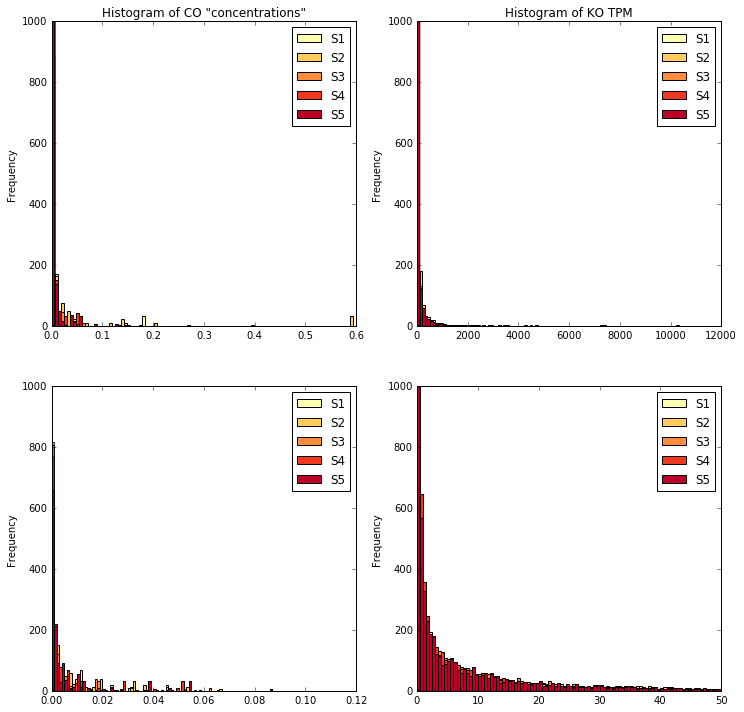

In [21]:
cmap=pal.colorbrewer.sequential.YlOrRd_5.get_mpl_colormap()
fig, axs=plt.subplots(2,2) 
fig.set_size_inches(12,12)
for ax in axs:
    for a in ax: 
        a.set_ylim([0,1000])
CO_RawData_pruned.plot(kind='hist', bins=100,colormap=cmap, ax=axs[0][0])
axs[0][0].set_title('Histogram of CO "concentrations"', size='large')
KO_RawData.plot(kind='hist', bins=100,colormap=cmap,ax=axs[0][1])
axs[0][1].set_title('Histogram of KO TPM', size='large')
CO_RawData_pruned.plot(kind='hist',  bins=100,colormap=cmap, range = [0,0.1],ax=axs[1][0])
KO_RawData.plot(kind='hist',  bins=100,colormap=cmap, range = [0,50],ax=axs[1][1])


In [22]:
def NormalizeToMean(DF):
    DF_meanNorm=DF.copy()
    out=DF_meanNorm.copy()
    DF_meanNorm['mean']=DF.mean(axis=1)

    for i in out.columns:
        out[i]=DF_meanNorm[i]/DF_meanNorm['mean']
    DF_meanNorm=DF_meanNorm.T.drop('mean').T
    return out

def NormalizeToMax(DF):
    DF_meanNorm=DF.copy()
    out=DF_meanNorm.copy()
    DF_meanNorm['max']=DF.max(axis=1)
    for i in out.columns:
        out[i]=DF_meanNorm[i]/DF_meanNorm['max']
    DF_meanNorm=DF_meanNorm.T.drop('max').T
    return out

def NormalizeToMean_CV(DF):
    out=DF.copy()
    out['mean']=DF.mean(axis=1)
    out['SD']=DF.std(axis=1)
    
    out['CV']=out['SD']/out['mean']
    return out

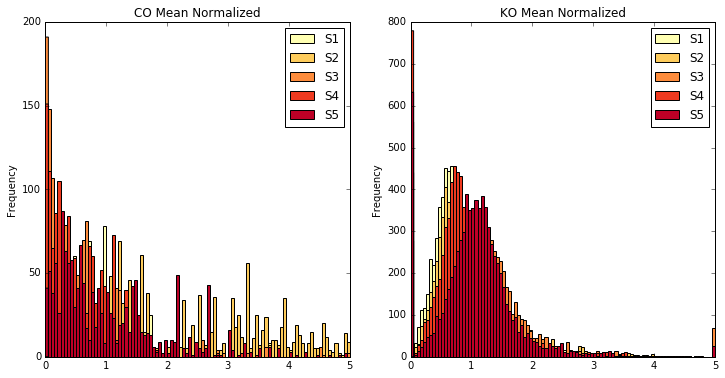

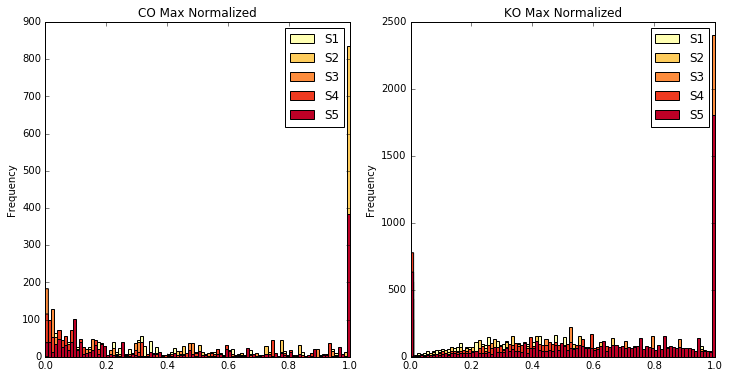

In [23]:
#several options for normalizing the data
CO_Norm2Mean=NormalizeToMean(CO_RawData_pruned) #this is what gets used in the original code
KO_Norm2Mean=NormalizeToMean(KO_RawData) #this is what gets used in the original code
CO_Norm2Max=NormalizeToMax(CO_RawData_pruned)
KO_Norm2Max=NormalizeToMax(KO_RawData)

cmap=pal.colorbrewer.sequential.YlOrRd_5.get_mpl_colormap()

fig, axs=plt.subplots(1,2) 
fig.set_size_inches(12,6)

kplt=KO_Norm2Mean.plot(kind='hist', bins=100, title='KO Mean Normalized', colormap=cmap, ax=axs[1])
cplt=CO_Norm2Mean.plot(kind='hist', bins=100, title='CO Mean Normalized', colormap=cmap, ax=axs[0])
fig, axs=plt.subplots(1,2) 
fig.set_size_inches(12,6)

kplt=KO_Norm2Max.plot(kind='hist', bins=100, title='KO Max Normalized', colormap=cmap, ax=axs[1])
cplt=CO_Norm2Max.plot(kind='hist', bins=100, title='CO Max Normalized', colormap=cmap, ax=axs[0])

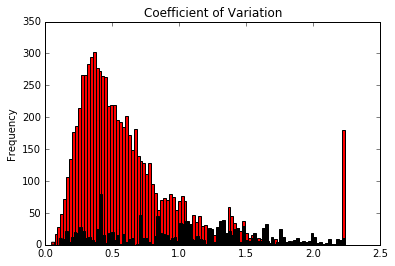

In [24]:
#could also try the normalize to mean, CV
cmap=pal.colorbrewer.diverging.PRGn_5.get_mpl_colormap()
fig,ax=plt.subplots(1)
CO_CV=NormalizeToMean_CV(CO_RawData_pruned)
KO_CV=NormalizeToMean_CV(KO_RawData)

#KL note: by using KO_CV.CV, this will only plot the 'CV' variable in the data frame
KO_CV.CV.plot(kind='hist', ax=ax, bins=100, color='r')
CO_CV.CV.plot(kind='hist', ax=ax, bins=100, title='Coefficient of Variation', color='k')
#fig.savefig('Coefficent of Variation')

In [25]:
#use _finalOption variable names to make life easier
KO_finalOption = KO_Norm2Mean.loc[AllKO].dropna()
CO_finalOption = CO_Norm2Mean.dropna() #already 'limited' this before the normalization

In [26]:
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

#this next line prints up some sort of pre-canned details about the program. 
print(__doc__) 

def kmeanCluster(data,nc):
    #kmeans=KMeans(n_clusters=nc)
    kmeans = KMeans(n_clusters = nc, max_iter = 1000, n_init = 50, init = 'random')
    kmeans.fit(data)
    newData=data.copy()
    newData['kmeans']=kmeans.labels_
    return newData
    
def PlotKmeans(KmeansPD, kSize=10, figSizeX=1, figSizeY=5, color='k'):
    KmeansPD['kmeans'].plot(kind='hist', bins=kSize, color=color)
    fig,axs=plt.subplots(figSizeX, figSizeY)
    axs=[item for sublist in axs for item in sublist]
    fig.set_size_inches(9,12)
    for ax, y in zip(axs,range(kSize)):
        pltData=KmeansPD[KmeansPD.kmeans==y].T.drop('kmeans')
        pltData.plot(ax=ax, legend=False, grid=False, color=color)

Automatically created module for IPython interactive environment


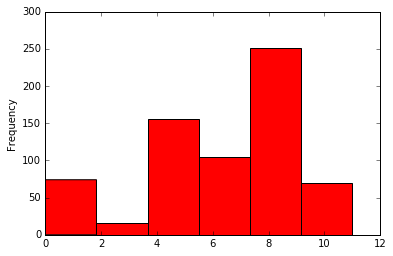

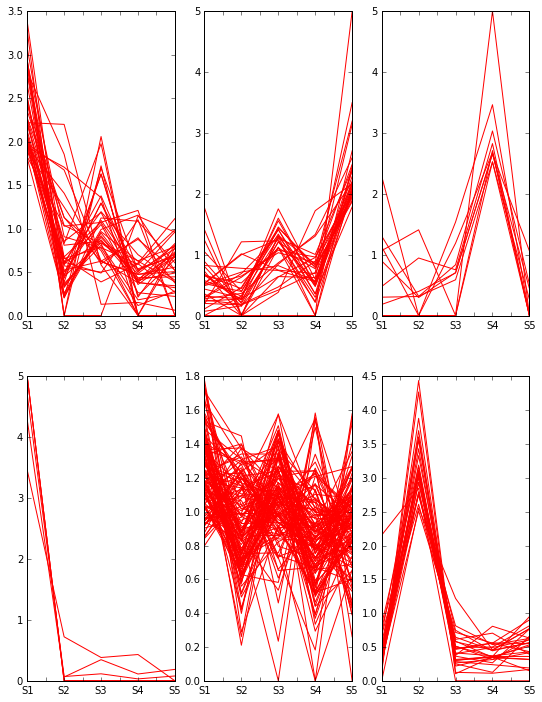

In [27]:
#run the Kmeans clustering on the KO data along first and plot results
#koClust=kmeanCluster(KO_limited_Norm2Mean, 15)
#PlotKmeans(koClust,15,3,5, 'r') 
koClust=kmeanCluster(KO_finalOption, 12)
PlotKmeans(koClust,6,2,3, 'r') 

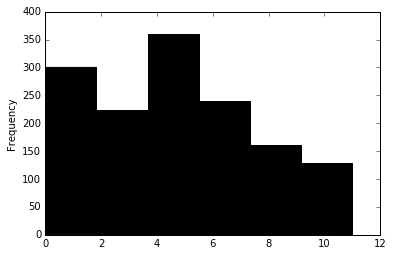

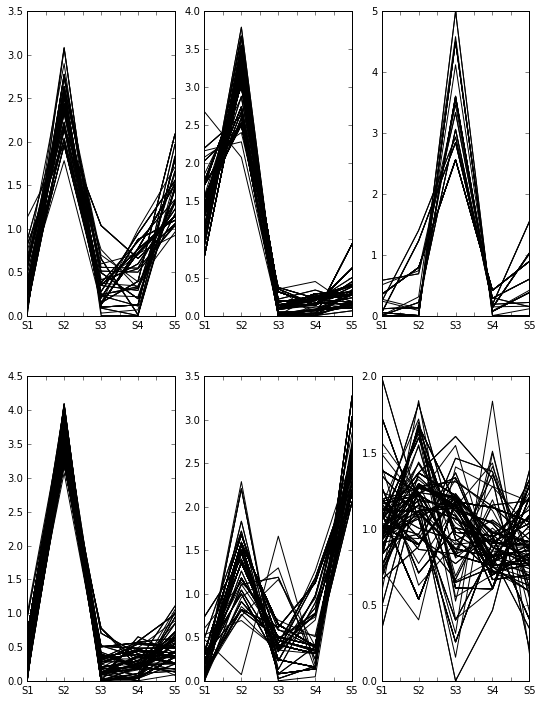

In [28]:
#plot up the results of one number of clusters for the CO data only
#coClust=kmeanCluster(CO_limited_Norm2Mean, 15)
#PlotKmeans(coClust,15,3,5, 'k') 
coClust=kmeanCluster(CO_finalOption.loc[:,(dayList)], 12)
PlotKmeans(coClust,6,2,3, 'k') 

From HA: By normalizing the data to the mean we can then (in theory) combine the two and cluster them together?
KL 8/20/2015 note: this is essentially a list with the CO and KO concatenated into a single data frame. Note that the actual kmeans clustering does not happen until after the silhoette analysis (bc need to set # clusters) and are using the silhouette analysis to do that.

#Do Kmeans on combined CO and KO data

In [29]:
##First, combine the CO and the KO data
#Combined_KO_CO_MeanNorm=KO_limited_Norm2Mean.append(CO_limited_Norm2Mean)
Combined_KO_CO_final=KO_finalOption.append(CO_finalOption.loc[:,(dayList)])

#go back to Kmeans and finding the right group

In [30]:
filename = 'nClustersRequired.py'
%run $filename

In [31]:
#cheat for the moment...save the data for the data I have as a CSV file and then read it in.
#figure out the format later.
dataFilename = 'NB_combined_for_kmeans.csv'
Combined_KO_CO_final.to_csv(dataFilename)

data = Data(dataFilename)
#pattern_labels are the rows...for us this will the RInumber
pattern_labels = []
patterns_data, pattern_labels = data.load_data()

In [32]:
def forest_run(dimensions, patterns, pattern_labels, metric='qe', fNamePrefix = '', k_up=20, k_down=2, simulations=55, iterations=50):
    """
    A method for watching Forest Gump run
    :param dimensions: the dimensionality of the data
    :param patterns: the data itself
    :param metric: the quality metric
    :fNamePrefix: put text in here if I want to add a unique prefix to the data file spit out at end
    :param k_up: the maximum number of clusters
    :param k_down: the minimum number of clusters
    :param simulations: the number of simulations for each k
    :param iterations: the number of iterations for each k-means pass
    """
    # variable to store the best result
    best_clustering = None
    # the quality of that result
    best_quality = 1000.00
    # write results out to file while simulating
    file_out = fNamePrefix + 'MonteCarloFinalResults' + '_' + metric + '.csv'
    #with open(file_out, 'w', newline='') as f: #newline doesn't work here
    with open(file_out,'w') as f:
        # different k values to test on
        for i in range(k_down, k_up):
            num_clusters = i
            # number of retries / simulations
            print('working on ' , i, '# of kmeans groups') #works, but doesn't look as I intended.
            
            for j in range(simulations):
                # create a clustering solution and apply k-means
                clustering = Clustering(dimensions, num_clusters, patterns, 0.0001)
                clustering.k_means_clustering(iterations)
                # used to compute quality of the solution
                quality = ClusteringQuality(clustering, 0.0001)
                this_quality = 0.0
                if metric == 'qe':
                    this_quality = quality.quantization_error()
                if metric == 'si':
                    this_quality = quality.average_silhouette_index()
                if metric == 'db':
                    this_quality = quality.davies_bouldin()
                # update the best clustering
                if this_quality < best_quality:
                    best_quality = this_quality
                    best_clustering = clustering
                    #print("Updated best clustering") #comment out, clogging up display
                # write result to the file
                result = [num_clusters, this_quality]
                for x in result:
                    f.write(str(x))
                    f.write(",")
                f.write("\n")
                f.flush()
                #print(j, result) #comment out, clogging up display
                
        # print the actual clustering out to console...comment this out, too much information
        #best_clustering.print_solution(pattern_labels)

In [33]:
dimensions = 5 #this is a function of the data itself. In the NB data we have five sampling days.
setSimulations = 100
setIterations = 100 #this is the default from the Turing Finance code
setKup = 20
setKdown = 2

In [34]:
#set if to False for the forest_run in the next three cells...that is time consuming

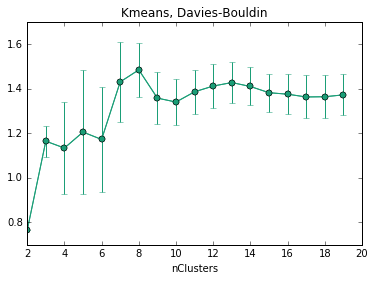

In [35]:
prefix = 'newKO_norm2mean_'

if False:   
    forest_run(dimensions, patterns_data, pattern_labels, metric='db', fNamePrefix = prefix,
           simulations=setSimulations, k_down=setKdown, k_up=setKup, iterations = setIterations)

#read in the results
riScores_db=pd.read_csv((prefix + 'MonteCarloFinalResults_db.csv'),header=None,delimiter=',',
                index_col=False,names=['nClusters', 'score'])

#optimal cluster solution has the smallest Davies-Bouldin index
grouped = riScores_db.groupby('nClusters')
means = grouped.mean().unstack()
errors = grouped.std().unstack()
fig, ax = plt.subplots()
plt.plot(range(setKdown,setKup),means,marker = 'o',color = '#1b9e77')
plt.errorbar(range(setKdown,setKup),means,errors,marker = 'o',color = '#1b9e77')
plt.title('Kmeans, Davies-Bouldin')
ax.set_xlabel('nClusters')
plt.show() #??? why is now showing all plots?

In [36]:
plt.gcf().canvas.get_supported_filetypes()

{u'eps': u'Encapsulated Postscript',
 u'jpeg': u'Joint Photographic Experts Group',
 u'jpg': u'Joint Photographic Experts Group',
 u'pdf': u'Portable Document Format',
 u'pgf': u'PGF code for LaTeX',
 u'png': u'Portable Network Graphics',
 u'ps': u'Postscript',
 u'raw': u'Raw RGBA bitmap',
 u'rgba': u'Raw RGBA bitmap',
 u'svg': u'Scalable Vector Graphics',
 u'svgz': u'Scalable Vector Graphics',
 u'tif': u'Tagged Image File Format',
 u'tiff': u'Tagged Image File Format'}

In [37]:
#need this to make a file where the text is actually editable (as oppossed to outlines)
#import matplotlib as mpl #KL moved to first cell 2/12/2016

#fig.savefig('DaviesBouldin_newKO.pdf')

In [38]:
if False:
    prefix = 'newKO_norm2mean_'

    if False:
        forest_run(dimensions, patterns_data, pattern_labels, metric='qe', fNamePrefix = prefix,
               simulations=setSimulations, k_down=setKdown, k_up=setKup, iterations = setIterations)

    #now read in the results
    riScores_qe=pd.read_csv((prefix + 'MonteCarloFinalResults_qe.csv'),header=None,delimiter=',',
                    index_col=False,names=['nClusters', 'score'])

    grouped = riScores_qe.groupby('nClusters')
    means = grouped.mean().unstack()
    errors = grouped.std().unstack()
    fig, ax = plt.subplots()
    plt.plot(range(setKdown,setKup),means,marker = 'o',color = '#1b9e77')
    plt.errorbar(range(setKdown,setKup),means,errors,marker = 'o',color = '#1b9e77')
    plt.title('Kmeans, Quantization error')
    ax.set_xlabel('nClusters')
    plt.show()

    #goal is to minimize quantization error. QE is the distance between a sample
    #and its representation. Lower quantization errors represent a good data cluster.

In [39]:
if False: ##silhouette is really slow cfd to the other
    prefix = 'newKO_norm2mean_'

    # #silhouette is quite slow cfd to the other two metrics
    if False:
        forest_run(dimensions, patterns_data, pattern_labels, metric='si', fNamePrefix = prefix,
               simulations=setSimulations, k_down=setKdown, k_up=setKup, iterations = setIterations)

    riScores_si=pd.read_csv((prefix + 'MonteCarloFinalResults_si.csv'),header=None,delimiter=',',
                    index_col=False,names=['nClusters', 'score'])


    ##note, want to maximize the silhouette value for each pattern in the dataset
    grouped = riScores_si.groupby('nClusters')
    means = grouped.mean().unstack()
    errors = grouped.std().unstack()
    fig, ax = plt.subplots()
    plt.plot(range(setKdown,setKup),means,marker = 'o',color = '#1b9e77')
    plt.errorbar(range(setKdown,setKup),means,errors,marker = 'o',color = '#1b9e77')
    plt.title('Kmeans, silhouette index')
    ax.set_xlabel('nClusters')
    plt.show()

    #remember, want to maximize this value

#Move forward with 'best' number of clusters

In [40]:
#setting # of clusters manually, also some good options with lower # of clusters I think
#this number will get used later when plotting up the BRITE categories and the Kmeans clusters
makeNclusters = 6

In [41]:
#do the K-means clustering with the final # of clusters
CcoClust=kmeanCluster(Combined_KO_CO_final, makeNclusters) #was 18 

#this will result in a data frame with the kmeans cluster as an added column. Remember
#this will have RI numbers for the compounds

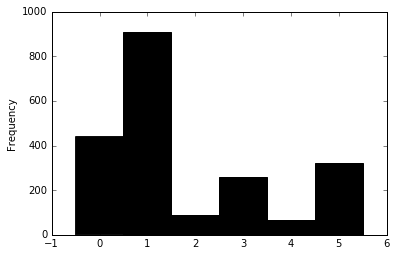

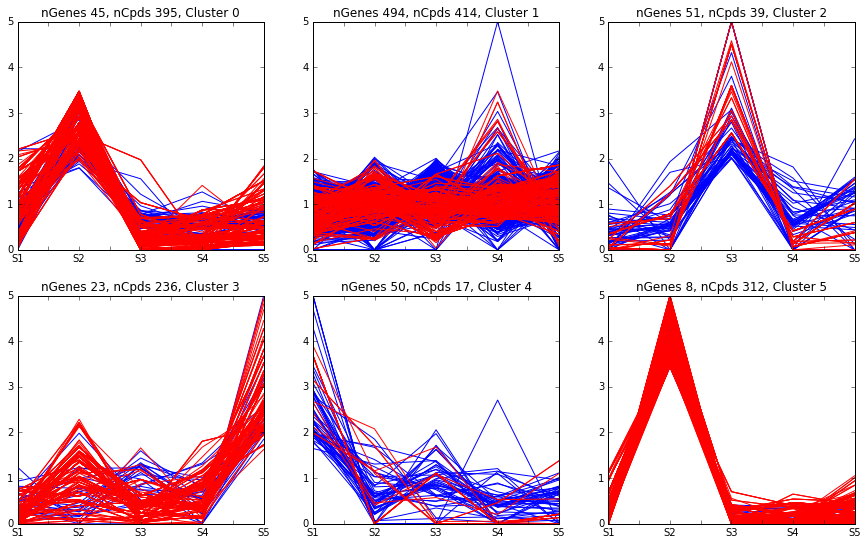

In [71]:
#import matplotlib as mpl
def PlotKmeansCombined(KmeansPD, kSize=10, figSizeX=2, figSizeY=3, color='k'):
    KmeansPD['kmeans'].plot(kind='hist', bins=kSize, color='k',range = (0,kSize),align = 'left')
    fig,axs=plt.subplots(figSizeX, figSizeY)
    axs=[item for sublist in axs for item in sublist]
    fig.set_size_inches(15,9)
    i=KmeansPD.index
    i=list(i)
    Ks=re.compile('K.*')
    #Cs=re.compile('C.*')
    Cs = re.compile('R.*') #this is the RInumber I created...for the moment, do not need the Cnumber
    C = filter(Cs.search, i)  
    K = filter(Ks.search, i)  
    Ksplit=KmeansPD.loc[K]
    Csplit=KmeansPD.loc[C]
    for ax, y in zip(axs,range(kSize)):
        KData=Ksplit[Ksplit.kmeans==y].T.drop('kmeans')
        KData.plot(ax=ax, legend=False, grid=False, color='b')
        CData=Csplit[Csplit.kmeans==y].T.drop('kmeans')
        CData.plot(ax=ax, legend=False, grid=False, color='r')
        SumKC=len(KData.T)+len(CData.T)
        KPct=(len(KData.T))
        CPct=(len(CData.T))
        ax.set_title('nGenes ' + str(KPct) + ', nCpds ' + str(CPct) + ', Cluster ' + str(y))
        ax.set_ylim([0,5])
    mpl.rcParams['pdf.fonttype'] = 42
    fig.savefig('CombinedKOandCO_Kmeans_regular.png')

# PlotKmeansCombined(CcoClust,makeNclusters,2,3, 'r') 
PlotKmeansCombined(CcoClust,makeNclusters) 

## Relating to taxonomy? 

In [43]:
from matplotlib_venn import venn3, venn3_circles

#load in the species/group information
Group_Species=pd.read_table('GrpSpecies',delimiter=' ').T.drop(['MMETSP', 
                                                  'MMETSP.1']).T.drop_duplicates().set_index('SName')

InsituTPMGrped=InsituTPM.groupby(['kID','sgID']).sum().reset_index().set_index('sgID')

Group_Species=Group_Species.reset_index()
#get the specific group combos
Dia=Group_Species[Group_Species['Grp']=='Bacillariophyta']
Din=Group_Species[Group_Species['Grp']=='Dinophyta']
Oth=Group_Species[((Group_Species['Grp']!='Dinophyta')&
                  (Group_Species['Grp']!='Bacillariophyta'))]
#get the insitu counts
Insitu_TPM_DIA=InsituTPMGrped.loc[Dia['SName']].groupby('kID').sum()
Insitu_TPM_DIN=InsituTPMGrped.loc[Din['SName']].groupby('kID').sum()
Insitu_TPM_Oth=InsituTPMGrped.loc[Oth['SName'].dropna()].groupby('kID').sum()

D=set(Insitu_TPM_DIA.index)
N=set(Insitu_TPM_DIN.index)
O=set(Insitu_TPM_Oth.index)
    

C:\Anaconda\lib\site-packages\matplotlib_venn-0.11-py2.7.egg\matplotlib_venn\_venn3.py:116: UserWarning: Bad circle positioning


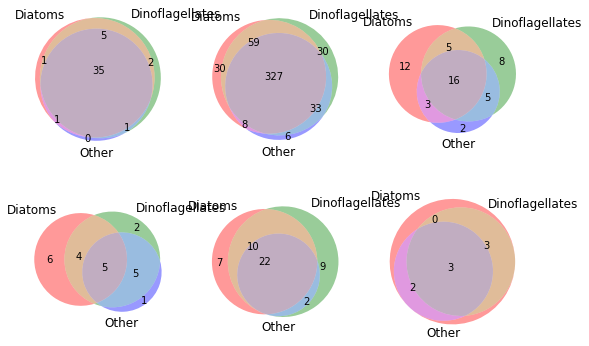

In [44]:
fig, axs=plt.subplots(2,3)
fig.set_size_inches(9,6)
axs=axs.flatten()
for i in set(CcoClust['kmeans']):
    ClusterK = CcoClust[CcoClust['kmeans']==i]
    ClusterKind=set([k for k in ClusterK.index if k.startswith('K')])

    Di=D.intersection(ClusterKind)
    Ni=N.intersection(ClusterKind)
    Oi=O.intersection(ClusterKind)
    
    set1 = Di
    set2 = Ni
    set3 = Oi

    ax=axs[i]
    v=venn3([set1, set2, set3], ('Diatoms', 'Dinoflagellates', 'Other'),ax=ax)

#fig.savefig('VennComp.pdf')

C:\Anaconda\lib\site-packages\matplotlib\cbook.py:136: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


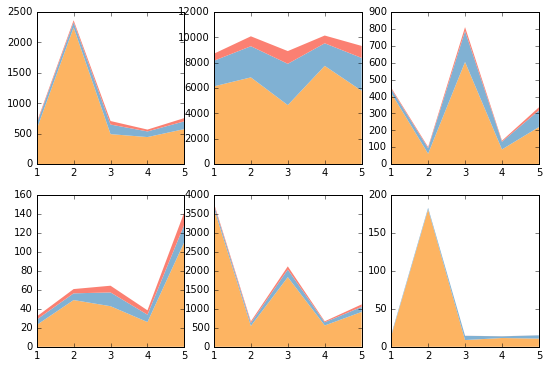

In [45]:
fig, axs=plt.subplots(2,3)
fig.set_size_inches(9,6)
axs=axs.flatten()
for i in set(CcoClust['kmeans']):
    ClusterK = CcoClust[CcoClust['kmeans']==i]
    ClusterKind=set([k for k in ClusterK.index if k.startswith('K')])

    Di=D.intersection(ClusterKind)
    Ni=N.intersection(ClusterKind)
    Oi=O.intersection(ClusterKind)

    Dsum=Insitu_TPM_DIA.loc[Di].sum()
    Nsum=Insitu_TPM_DIN.loc[Ni].sum()
    Osum=Insitu_TPM_Oth.loc[Di].sum()

    ax=axs[i]
    ax.stackplot(range(5), Dsum, Nsum, Osum, colors=
                 pal.colorbrewer.qualitative.Set3_6_r.hex_colors, lw=0)
    ax.set_xticks(range(5))
    ax.set_xticklabels([1,2,3,4,5])
    
#fig.savefig('ClusterTotalTPM.pdf')

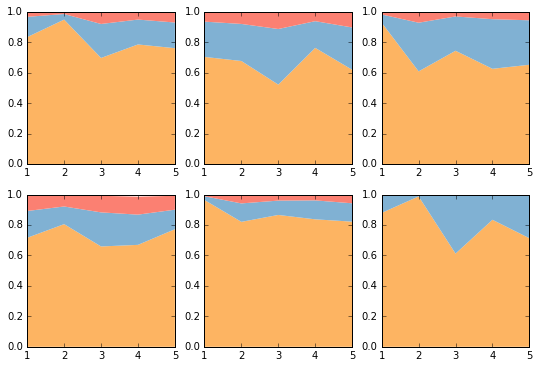

In [46]:
fig, axs=plt.subplots(2,3)
fig.set_size_inches(9,6)
axs=axs.flatten()
for i in set(CcoClust['kmeans']):
    ClusterK = CcoClust[CcoClust['kmeans']==i]
    ClusterKind=set([k for k in ClusterK.index if k.startswith('K')])

    Di=D.intersection(ClusterKind)
    Ni=N.intersection(ClusterKind)
    Oi=O.intersection(ClusterKind)
    
    Ksum=KO_RawData.loc[ClusterKind].sum()

    Dsum=Insitu_TPM_DIA.loc[Di].sum()/Ksum
    Nsum=Insitu_TPM_DIN.loc[Ni].sum()/Ksum
    Osum=Insitu_TPM_Oth.loc[Di].sum()/Ksum

    
    ax=axs[i]
    ax.stackplot(range(5), Dsum, Nsum, Osum, colors=
                 pal.colorbrewer.qualitative.Set3_6_r.hex_colors, lw=0)
    ax.set_xticks(range(5))
    ax.set_xticklabels([1,2,3,4,5])
    ax.set_ylim(0,1)

    #fig.savefig('ClusterPercentTPM.pdf')

(0, 1)

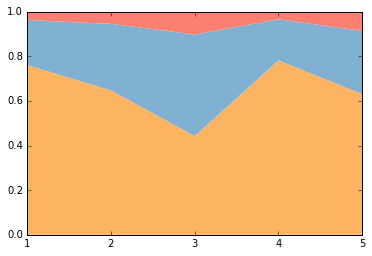

In [47]:
kid='K00939'
allK=InsituTPMGrped[InsituTPMGrped['kID']==kid].sum()
allK=allK.drop('kID')
allK=allK.astype('float')
if kid in Insitu_TPM_DIA.index.tolist():
    Dk=Insitu_TPM_DIA.loc[kid]/allK
else: 
    Dk = 0/allK

if kid in Insitu_TPM_DIN.index.tolist():
    Nk=Insitu_TPM_DIN.loc[kid]/allK
else:
    Nk = 0/allK
    
if kid in Insitu_TPM_Oth.index.tolist():
    Ok=Insitu_TPM_Oth.loc[kid]/allK
else:
    Ok = 0/allK
    
fig,ax=plt.subplots(1)
ax.stackplot(range(5), Dk, Nk, Ok, colors=pal.colorbrewer.qualitative.Set3_6_r.hex_colors, lw=0)
ax.set_xticks(range(5))
ax.set_xticklabels([1,2,3,4,5])
ax.set_ylim(0,1)


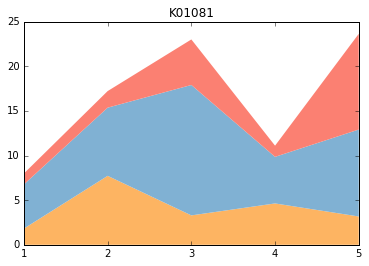

In [48]:
kid='K01081'
allK=InsituTPMGrped[InsituTPMGrped['kID']==kid].sum()
allK=allK.drop('kID')
allK=allK.astype('float')
allK

if kid in Insitu_TPM_DIA.index.tolist():
    Dk=Insitu_TPM_DIA.loc[kid]
else: 
    Dk = 0/allK

if kid in Insitu_TPM_DIN.index.tolist():
    Nk=Insitu_TPM_DIN.loc[kid]
else:
    Nk = 0/allK
    
if kid in Insitu_TPM_Oth.index.tolist():
    Ok=Insitu_TPM_Oth.loc[kid]
else:
    Ok = 0/allK
    
fig,ax=plt.subplots(1)
ax.stackplot(range(5), Dk, Nk, Ok, colors=pal.colorbrewer.qualitative.Set3_6_r.hex_colors, lw=0)
ax.set_xticks(range(5))
ax.set_xticklabels([1,2,3,4,5])
plt.title(kid)
# ax.set_ylim(0,1)
#fig.savefig(kid +'_numbers_forTalk.pdf')

In [49]:
colors=pal.colorbrewer.qualitative.Set3_6_r.hex_colors
colors

['#FDB462', '#80B1D3', '#FB8072', '#BEBADA', '#FFFFB3', '#8DD3C7']

###focus on things with common linked reactions...

In [50]:
#But...for the CheckRelatedness...do need to go back to the cNumber...
#for now, easiest to just make yet another matrix and put the cNumbers back in.
forRelatedness = CcoClust.copy(deep=True) #make a copy of the CcoClust data frame
forRelatedness.insert(0,'KEGG',"") #add a column called 'KEGG'
forRelatedness.head(5)

,KEGG,S1,S2,S3,S4,S5,kmeans
K00509,,0.155998,4.439468,0.124876,0.112028,0.167630,5
K00503,,0.456410,0.907973,1.482439,0.867102,1.286075,1
K00500,,0.429821,1.878668,0.685829,0.486034,1.519648,1
K00505,,1.063362,0.838684,1.095300,0.591648,1.411006,1
K01101,,0.392561,0.603830,0.881764,2.282164,0.839680,1


In [51]:
for idx in range(0,len(forRelatedness)):
    t = forRelatedness.iloc[idx,:].name

    if t[0]=='R':
        #go find the matching cNumber in CO_RawData_all
        t2 = CO_fromMATLAB.loc[t,('cNumber')]
        forRelatedness.ix[idx,('KEGG')] = t2
    elif t[0] == 'K':
        #just copy the K number over
        forRelatedness.ix[idx,('KEGG')] = t

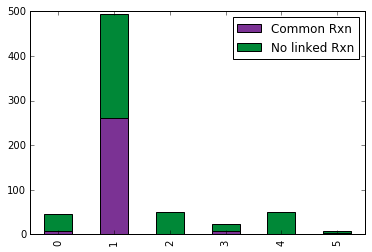

In [52]:
def CheckRelatedness(inClust,nC):
    df=pd.DataFrame(columns=['Common Rxn','No linked Rxn'], index=range(nC))
    for n in range(nC):
        kClust=inClust[inClust.kmeans==n]
        #i=kClust.index
        i = kClust.KEGG #change the new column I created with Cnumbers and Knumbers
        i=list(i)
        #note...re is one of the things imported at the very beginning
        Csearc=re.compile('C.*') #re is regular expression...perl-like; re.compile bascially makes an object 
        Cs = filter(Csearc.search, i)
        Ksearc=re.compile('K.*')
        Kis = filter(Ksearc.search, i)
        Kis=set(Kis)
        Ks=[]
        for c in Cs:
            if c in CO_withKO.keys():
                Ks.append(CO_withKO[c]['Related KO'])
        Ks=set([item for sublist in Ks for item in sublist])
        df.loc[n,'Common Rxn']=len(Kis.intersection(Ks))
        df.loc[n, 'No linked Rxn']=len(Kis)-len(Kis.intersection(Ks))
    df.plot(kind='bar', stacked=True, colormap=pal.colorbrewer.diverging.PRGn_5.get_mpl_colormap(), grid=False)
     
CheckRelatedness(forRelatedness, makeNclusters)

pick up here to change to using biopython module to get maps with merged KO and CO data within a K means group
12 November 2015

In [53]:
from Bio import SeqIO
from Bio.KEGG.REST import *
from Bio.KEGG.KGML import KGML_parser
from Bio.Graphics.KGML_vis import KGMLCanvas
from Bio.Graphics.ColorSpiral import ColorSpiral

from IPython.display import Image, HTML

# import random #seems like I can probably skip this, but just comment out in case that is not true

# A bit of code that will help us display the PDF output
def PDF(filename):
    return HTML('<iframe src=%s width=700 height=350></iframe>' % filename)

# A bit of helper code to shorten long text
def head(text, lines=10):
    """ Print the first lines lines of the passed text.
    """
    print '\n'.join(text.split('\n')[:lines] + ['[...]'])

In [54]:
#set up a function to get the list of K orthologues for a given pathway (must be defined as ko00140 NOT map00140)
def getKfrom_ko(ko_id):
    pathway_file = kegg_get(ko_id).read()  # query and read the pathway
    K_list = []

    current_section = None
    for line in pathway_file.rstrip().split("\n"):
        section = line[:12].strip()  # section names are within 12 columns
        if not section == "":
            current_section = section
        if current_section == "ORTHOLOGY":
            K_identifiers = line[12:].split("; ")
            t = K_identifiers[0]
            K_id = t[0:6]

            if not K_id in K_list:
                K_list.append(K_id)
    return K_list

In [55]:
#set up a function to get the list of compounds for a given pathway (must be defined as ko00140 NOT map00140)
def getCfrom_ko(ko_id):
    pathway_file = kegg_get(ko_id).read()  # query and read the pathway
    compound_list = []

    current_section = None
    for line in pathway_file.rstrip().split("\n"):
        section = line[:12].strip()  # section names are within 12 columns
        if not section == "":
            current_section = section
        if current_section == "COMPOUND":
            compound_identifiers = line[12:].split("; ")
            t = compound_identifiers[0]
            compound_id = t[0:6]

            if not compound_id in compound_list:
                compound_list.append(compound_id)
    return compound_list

In [56]:
allPathways = kegg_list("pathway").read()
len(allPathways.split('\n'))

486

In [57]:
#so, 481 pathways at KEGG, not all of which are likely to be interesting.
#up to 483 on 12/16/2015
#up to 485 by 3/30/2016

In [58]:
trimPath = []
current_section = None
for line in allPathways.rstrip().split("\n"):
#     Tracer()()
    tp = line[8:13]
    
    trimPath.append('ko' + tp)

In [59]:
#have some cases where KEGG will send back a pathway, but the pathway itself is not searchable...seems to 
#be a KEGG bug, 'ko00351' was first, then realized there are many of these,
#did this list manually since I thought it would be short...
toDelete = ('ko00351','ko01010','ko01060', 'ko01061',  'ko01062', 'ko01063', 'ko01064', 'ko01065', 'ko01066',
 'ko01070', 'ko07011', 'ko07012', 'ko07013', 'ko07014', 'ko07015', 'ko07016', 'ko07017', 'ko07018', 'ko07019',
 'ko07020', 'ko07021', 'ko07023', 'ko07024', 'ko07025', 'ko07026', 'ko07027', 'ko07028', 'ko07029', 'ko07030',
 'ko07031', 'ko07032', 'ko07033', 'ko07034', 'ko07035', 'ko07036', 'ko07037', 'ko07038', 'ko07039', 'ko07040',
 'ko07041', 'ko07042', 'ko07043', 'ko07044', 'ko07045', 'ko07046', 'ko07047', 'ko07048', 'ko07049', 'ko07050',
 'ko07051', 'ko07052', 'ko07053', 'ko07054', 'ko07055', 'ko07056', 'ko07057', 'ko07110', 'ko07112', 'ko07114',
 'ko07117', 'ko07211', 'ko07212', 'ko07213', 'ko07214', 'ko07215', 'ko07216', 'ko07217', 'ko07218', 'ko07219',
 'ko07220', 'ko07221', 'ko07222', 'ko07223', 'ko07224', 'ko07225', 'ko07226', 'ko07227', 'ko07228', 'ko07229',
 'ko07230', 'ko07231', 'ko07232', 'ko07233', 'ko07234', 'ko07235','ko04933')

#probably a way to do this without the for loop, but this will work
for item in toDelete:
    trimPath.remove(item)

In [60]:
# #useColors = pal.colorbrewer.diverging.PiYG_4.hex_colors
# useColors = pal.colorbrewer.qualitative.Set3_4_r.hex_colors
# # useColors = pal.colorbrewer.qualitative.Accent_4_r.hex_colors
# # useColors = pal.colorbrewer.qualitative.Dark2_4.hex_colors
# # cmap=pal.colorbrewer.sequential.YlOrRd_5.get_mpl_colormap()

##manually set the colors [red,white,blue]
#useColors = ('#e41a1c','#f7f7f7','#377eb8') 

#add a fourth color: items in the data set, but not linked to a gene or cpd
useColors = pal.colorbrewer.qualitative.Set1_3.hex_colors
useColors.insert(1,'#f7f7f7') ## [red,white,blue, green]

##Filtering pathways to plot based on reactions

In [61]:
useColors

['#E41A1C', '#f7f7f7', '#377EB8', '#4DAF4A']

In [62]:
shortList = ['ko03010','ko03013']

In [63]:
#Liz wants to see pathways, reactions, and species plotted up for everything...so change this next cell
#at the same time, make a list of what has actually been plotted to address the need for a list
#of stuff to send to Sonya, Tatiana, and Bethanie

temp = ['pathwayName']
for item in range(makeNclusters):
    temp.append('Km' + str(item))

#keepPathwayInfo = pd.DataFrame(index = shortList, columns = temp)
keepPathwayInfo = pd.DataFrame(index = trimPath, columns = temp)
del temp

In [65]:
colLabel = ['nCpds','nGenes'] #starting with this is easiest - makes one list, no need to flatten

for item in range(makeNclusters):
    colLabel.append('Km' + str(item) + '_cpd')
    colLabel.append('Km' + str(item) + '_gene')
    
gatherCounts = pd.DataFrame(0, index = trimPath, columns = colLabel)

#this set of looks works on one pathway at a time, only plotting if I get more than one case with a reaction
#containing both a gene and a metabolite within the pathway of interest
if True: #can be time consuming (off for editing).
    
    #setup the strings to match first
    rnString = re.compile('(?:[rn:R])(\d+)$') #will return R00190
    cpdString = re.compile('(?:[cpd:C])(\d+)$') #will return C00190

    size = 20 #turns out I can increase the size of the compounds in the plots

    for kn in range(makeNclusters):
    #for kn in range(5,6): 
    #for kn in range(0):    

        fullSet = set(forRelatedness.KEGG)
        oneK = forRelatedness[forRelatedness.kmeans == kn] #get gene & transcript information for one Kmeans group
        getKm = 'Km' + str(kn)

        #check if the directories exist 
        directoryPDF = 'plots_6Kmeans' + str(kn) + '/pathway_files'
        if not os.path.exists(directoryPDF):
            os.makedirs(directoryPDF)

        #check if the directories exist 
        directoryPNG = 'plots_6Kmeans' + str(kn) + '/reaction_files'
        if not os.path.exists(directoryPNG):
            os.makedirs(directoryPNG) 
            
        #check if the directories exist 
        directorySpecies = 'plots_6Kmeans' + str(kn) + '/species_files'
        if not os.path.exists(directorySpecies):
            os.makedirs(directorySpecies) 
        
        for item in trimPath: #searching within one pathway at a time
        #for item in shortList: #short list for testing
            #print kn, item
            plotPathway = [] #gather up yes/no and will only plot if have linked genes/mtabs
        
            genes = getKfrom_ko(item)
            compounds = getCfrom_ko(item)

            gatherCounts.loc[item,'nCpds'] = len(compounds)
            gatherCounts.loc[item,'nGenes'] = len(genes)     

            #have to track genes and compounds differently for the biopython plotting later on 
            setG = set(genes)
            setC = set(compounds)
            setB = set(oneK.KEGG)
            intGenes = setG.intersection(setB)
            intCompounds = setC.intersection(setB)

            gatherCounts.loc[item,(getKm + '_gene')] = len(intGenes)
            gatherCounts.loc[item,(getKm + '_cpd')] = len(intCompounds)

            #now, before plotting, look for intersection of genes/compounds using the reaction information
            current_section = None
            
            for gen in intGenes: #go through each gene...one at a time
                #Tracer()()
                rnList = kegg_link('reaction',gen).read() #get the list of reactions for that gene
                
                #can have cases where there is a gene and no reaction (K02906 for example). This returns rnList = '\n'
                #since this is not actually empty...need a few way to filter those out
                test = '\n'
                if test != rnList: #most cases....will move on
                
                    for line in rnList.rstrip().split('\n'):
                        countCpd = []
                        countGene = []

                        m = rnString.search(line) #get the reaction number

                        cpdList = kegg_link('cpd',m.group(0)).read() #now go get the compounds for that reaction

                        #can have no compounds in a reaction (only glycans, begin with G, nothing I have matched)
                        if len(cpdList) > 1: #will be true if cpdList includes compounds
                            for line2 in cpdList.rstrip().split('\n'):
                                m2 = cpdString.search(line2).group(0)
                                #now that I have a compound, check if it is in intCompounds
                                #Tracer()()
                                if m2 in intCompounds:
                                    #Tracer()()
                                    countCpd.append(m2) 
                                    countGene.append(gen)
                                    plotPathway.append('yes')

                        ##Now, plot the PNG files (one for each reaction within a pathway)
                        if len(countCpd) > 0:
                            kData = pd.DataFrame(columns = dayList)
                            for k in set(countGene):
                                kData = kData.append(oneK.ix[k,dayList])

                            cData = pd.DataFrame(columns = dayList)
                            for co in set(countCpd):
                                #convert CO to RI, can have multiple options
                                j = findRInumber(oneK,co)
                                cData = cData.append(oneK.loc[j,dayList])

                            fig,ax = plt.subplots(1)
                            cData.T.plot(color = 'k',ax=ax)
                            kData.T.plot(color = 'r',ax=ax)

                            handles, labels = ax.get_legend_handles_labels()
                            #convert the RI numbers to COnumbers for the figure
                            for ia, a in enumerate(labels):
                                #add compound/gene name to the legend
                                if a[0]== 'R':
                                    tLabel = convertRItoCO(CO_fromMATLAB,a)
                                    fn = kegg_list(tLabel).read()                          
                                    labels[ia] = fn
                                elif a[0] == 'K':
                                    fn = kegg_list(a).read()
                                    labels[ia] = fn

                            #Tracer()()
                            ax.legend(handles, labels, bbox_to_anchor = ([-1, 0.5]))
                            fig.suptitle('pathway ' + item + ', Kmeans grp ' + str(kn))
                            pngName = 'pathway' + item + '_' + m.group(0) + '.png'
                            fig.savefig(directoryPNG + '/' + pngName, bbox_inches = 'tight')
                            pngName = None #empty it in case that is where I am having issues
                            plt.close()
                            #Tracer()()

            if len(plotPathway) > 0: # not empty
                ## plot the pathway map for this pathway, get details from KEGG for plotting
                pathway = KGML_parser.read(kegg_get(item, "kgml"))
                
                #Liz wants the pathway information, item is the pathway number
                keepPathwayInfo.loc[item,('Km' + str(kn))] = 'yes'
                #get the pathway name from KEGG (guessing this will be slow)
                t = kegg_list(item).read()
                for line in t.rstrip().split("path:" + item + "\t"):
                    keepPathwayInfo.loc[item,'pathwayName'] = line
                
                for element in pathway.orthologs:
                    #print element.name
                    for graphic in element.graphics:
                        tg = element.name[3:9] #skip over the 'ko:'

                        if (tg in intGenes):
                            #in the pathway AND in the set for this particular K means group
                            graphic.bgcolor = useColors[0] #red
                            
                            #if this is something in the pathway, plot up the species for the K number
                            allK=InsituTPMGrped[InsituTPMGrped['kID']==tg].sum()
                            allK=allK.drop('kID')
                            allK=allK.astype('float')
                            allK

                            if tg in Insitu_TPM_DIA.index.tolist():
                                Dk=Insitu_TPM_DIA.loc[tg]
                            else: 
                                Dk = 0/allK

                            if tg in Insitu_TPM_DIN.index.tolist():
                                Nk=Insitu_TPM_DIN.loc[tg]
                            else:
                                Nk = 0/allK

                            if tg in Insitu_TPM_Oth.index.tolist():
                                Ok=Insitu_TPM_Oth.loc[tg]
                            else:
                                Ok = 0/allK
    
                            fig,ax=plt.subplots(1)
                            ax.stackplot(range(5), Dk, Nk, Ok, colors=pal.colorbrewer.qualitative.Set3_6_r.hex_colors, lw=0)
                            ax.set_xticks(range(5))
                            ax.set_xticklabels([1,2,3,4,5])
                            ax.set_ylabel('In situ TPM')
                            plt.title(tg + ', lt orange=diatoms, blue=dinos, dk orange=other')
                            fig.savefig(directorySpecies + '/' + tg + '_species.png',bbox_inches='tight')
                            plt.close()


                        elif (tg in fullSet) and (tg in genes) and (tg not in intGenes):
                            #in the pathway AND in the set of genes from RI, but *not* in this Kmeans group
                            graphic.bgcolor = useColors[2] #blue

                        elif (tg not in fullSet) and (tg in genes) and (tg not in KO_Norm2Mean.index.tolist()):
                            #in the pathway, but *not* in anything from the RI samples
                            graphic.bgcolor = useColors[1] #white
                        
                        elif (tg not in fullSet) and (tg in genes) and (tg in KO_Norm2Mean.index.tolist()): #seems like a hack
                            #an unconnected gene in the RI data
                            graphic.bgcolor = useColors[3] #green

                # Change the colours of compounds
                for element in pathway.compounds:
                    for graphic in element.graphics:
                        tc = element.name[4:10] #skip over the 'cpd:'

                        if (tc in intCompounds):
                            #in the pathway AND in the set for this particular K means group
                            graphic.bgcolor = useColors[0] #red
                            graphic.width = size
                            graphic.height = size
                            
                        elif (tc in fullSet) and (tc in compounds) and (tc not in intCompounds):
                            #in the pathway AND in the set of compounds from RI, but *not* in this Kmeans group
                            graphic.bgcolor = useColors[2] #blue
                            graphic.width = size
                            graphic.height = size

                        elif (tc not in fullSet) and (tc in compounds) and (tc not in CO_fromMATLAB.cNumber.values):
                            #in the pathway, but *not* in anything from the RI samples
                            graphic.bgcolor = useColors[1] #white
                                                      
                        elif (tc not in fullSet) and (tc in compounds) and (tc in CO_fromMATLAB.cNumber.values): #seems like a hack
                            #unconnected compound in the RI data
                            graphic.bgcolor = useColors[3] #green
                            graphic.width = size
                            graphic.height = size

                canvas = KGMLCanvas(pathway, import_imagemap=True)
                pdfName = 'mapWithColors_' + str(item) + '.pdf'
                canvas.draw(directoryPDF + '/' + pdfName)
                pdfName = None #empty it in case that is where I am having issues
                #PDF(fName) #comment this out to *not* see the PDF within the iPython notebook':

In [67]:
keepPathwayInfo.dropna(how = 'all',inplace = True)
keepPathwayInfo.head(5)

,pathwayName,Km0,Km1,Km2,Km3,Km4,Km5
ko00020,Citrate cycle (TCA cycle),NaN,yes,NaN,NaN,NaN,NaN
ko00040,Pentose and glucuronate interconversions,NaN,yes,NaN,NaN,NaN,NaN
ko00051,Fructose and mannose metabolism,NaN,yes,NaN,NaN,NaN,NaN
ko00052,Galactose metabolism,NaN,yes,NaN,NaN,NaN,NaN
ko00053,Ascorbate and aldarate metabolism,NaN,yes,NaN,NaN,NaN,NaN


In [69]:
keepPathwayInfo.shape

(67, 7)

In [70]:
keepPathwayInfo.to_csv('pathways_byKmeans_regular.2016.04.06.csv')

In [ ]:
#want to export gatherCounts, with the added pathway name as a new column
gatherCounts['pathwayInfo'] = ''
gatherCounts['pathwayGroup_A'] = ''
gatherCounts['pathwayGroup_B'] = ''
gatherCounts['pathwayGroup_C'] = ''

In [ ]:
#organize pathways into the groups defined in the BRITE file (didn't work well for compounds, 
#but the pathway groups seem useful)
def ReadBRITEfile(briteFile):
    forBrite = pd.DataFrame(columns = ['map','A','B','C','wholeThing'])
    # set up the expressions to match each level in the BRITE hierarchy
    
    textA = re.compile(r'(^A<b>)(.+)(</b>)\s*(.*)$')
    textB = re.compile(r'(^B)\s*(.*)$')
    textC = re.compile(r'(\d+)\s*(.*)$')
    #this relies on the fact that the rows are in order: A, with B subheadings, then C subheadings
    setA = []
    idxA = []

    setB = []
    setC = []

    with open(briteFile) as f:
        for idx,line in enumerate(f):
            if line[0] is not '#': #skip over the comments
                mA = textA.search(line) 
                mB = textB.search(line) 
                mC = textC.search(line) 
                if mA:
                    setA = mA.group(2)
                    #house cleaning (probably c)
                    idxA = idx
                    forBrite.loc[idx,'A'] = setA
                    forBrite.loc[idx,'wholeThing'] = line #using this as a double check for now
                    #forBrite.loc[idx,'map'] = mC.group(1)
                elif mB:
                    setB = mB.group(2)
                    forBrite.loc[idx,'A'] = setA
                    forBrite.loc[idx,'B'] = setB
                    forBrite.loc[idx,'wholeThing'] = line
                    #forBrite.loc[idx,'map'] = mC.group(1)
                elif mC:
                    #Tracer()()
                    setC = mC.group(2)
                    forBrite.loc[idx,'A'] = setA
                    forBrite.loc[idx,'B'] = setB
                    forBrite.loc[idx,'C'] = setC
                    forBrite.loc[idx,'wholeThing'] = line
                    forBrite.loc[idx,'map'] = mC.group(1)

        return forBrite

In [ ]:
D = glob.glob('br08901.keg') #from http://www.genome.jp/kegg-bin/get_htext?br08901.keg; 12/15/2015
allBRITE=[]
for idx,nof in enumerate(D):
    allBRITE = ReadBRITEfile(nof) 
    
allBRITE.loc[allBRITE['map']=='01100']

In [ ]:
#KEGG seems to be updating pathways...finding some where gatherCounts has a pathway, 
#but it is missing from the BRITE file
#ko04139, added to KEGG 12/1/15, pathway is: 'regulation of mitophagy' 
#ko04211, added to KEGG 12/14/15, pathway is 'longevity regulating pathway mammal
#let's delete it from gatherCounts

gatherCounts = gatherCounts.drop(['ko04139'])
gatherCounts = gatherCounts.drop(['ko04211'])
gatherCounts = gatherCounts.drop(['ko04212']) #longevity regularing pathway - worm


#note that this cell will only work once

In [ ]:
gatherCounts = gatherCounts.drop(['ko04213'])

In [ ]:
#put the pathway name and group into the data frame before exporting it
for item in gatherCounts.index:
    #if this error appears: IndexError: index 0 is out of bounds for axis 0 with size 0
    #KEGG has updated a pathway, but not the BRITE file (see above...) have to delete that 
    #row from GatherCounts; run again with the next row uncommented out to find the culprit.
    #print item
    
    pathstr = kegg_list(item).read()
    #this next line splits the string at the '\t', then keeps the piece at index = 1, and strips off the '\n'
    gatherCounts.loc[item,('pathwayInfo')] = pathstr.split('\t')[1].rstrip()
    
    t = allBRITE.loc[allBRITE['map']==item[2:]]  

    gatherCounts.set_value(item,'pathwayGroup_A',t['A'].values[0])
    gatherCounts.set_value(item,'pathwayGroup_B',t['B'].values[0])
    gatherCounts.set_value(item,'pathwayGroup_C',t['C'].values[0])
    
    del t

In [ ]:
#now...save all that so I don't have to do this everytime BUT be careful with re-assigning K means group numbers!
cpk.dump(gatherCounts, open('gatherCounts_norm2mean.2016.03.31.pickle', 'wb'))


In [ ]:
#and now...read in the file...can use this without having to go through the pain of rerunning gatherCounts
gatherCounts = cpk.load(open('gatherCounts_norm2mean.2016.03.31.pickle','rb'))
gatherCounts.head(2)

In [ ]:
colLabel

In [ ]:
newCols = colLabel[2:]

In [ ]:
newCols

In [ ]:
cpdCols = colLabel[2::2]
cpdCols 

In [ ]:
geneCols = colLabel[3::2]
geneCols

In [ ]:
# plot one compound or gene (for paper)
oneCO = 'C02666'
plotOne = forRelatedness[forRelatedness['KEGG']==oneCO]
kData = plotOne.ix[:,dayList]
fig,ax = plt.subplots(1)
kData.T.plot(color = 'r',ax=ax, ylim = [0,5])

handles, labels = ax.get_legend_handles_labels()
#convert the RI numbers to COnumbers for the figure
for ia, a in enumerate(labels):
    #add compound/gene name to the legend
    ##kegg_list('C00020').read()
    #will have annoying tabs, use this to find them
    if a[0]== 'R':
        tLabel = convertRItoCO(CO_fromMATLAB,a)
        fn = kegg_list(tLabel).read()                          
        labels[ia] = fn
    elif a[0] == 'K':
        fn = kegg_list(a).read()
        labels[ia] = fn

ax.legend(handles, labels, bbox_to_anchor = ([-1, 0.5]))
fig.suptitle('pathway ' + item + ', Kmeans grp ' + str(kn))
#pngName = 'pathway' + item + '_' + m.group(0) + '_' + oneCO + '.png'
# fig.savefig(pngName)

In [ ]:
#how many reactions does AMP appear in? pantothenic acid?

In [ ]:
kegg_list('C00020').read()

In [ ]:
cpdList = kegg_link('reaction','C00020') #how many reactions does AMP participate in?

In [ ]:
#set up a function to get the list of compounds for a given pathway (must be defined as ko00140 NOT map00140)
def countReactions_byCompound(c_id):
    cpdList = kegg_link('reaction',c_id).read()  # query and read the pathway
    nReactions = 0

    for line in cpdList.rstrip().split("\n"):
        nReactions = nReactions + 1
    
    return nReactions

countReactions_byCompound('C00864')

In [ ]:
#set up a function to get the list of compounds for a given pathway (must be defined as ko00140 NOT map00140)
def countReactions_byGene(k_id):
    cpdList = kegg_link('reaction',k_id).read()  # query and read the pathway
    nReactions = 0

    for line in cpdList.rstrip().split("\n"):
        nReactions = nReactions + 1
    
    return nReactions

countReactions_byGene('K00944')

In [ ]:
kegg_link('module','C00020').read()

In [ ]:
kegg_find('module','m00049').read()

In [ ]:
kegg_find('pathway','map00230').read()

In [ ]:
#this provides the complete list of pathways at KEGG:
test = kegg_list('pathway')
#can see the list with this command:
#test.read()

In [ ]:
kegg_find('ko','K11752').read()

In [ ]:
##bingo. This will provide both the genes and the compounds within a given pathway (lots of details)
#print kegg_get('ko00230').read()

In [ ]:
kegg_link('cpd','cpd:C00020').read()

In [ ]:
kegg_link('pathway','C00020').read()

In [ ]:
kegg_link('brite','K00926').read()

In [ ]:
kegg_link('brite','C00020').read()

In [ ]:
#this version spits out the heatmap since that seems to be the prefered options

In [ ]:
#this makes a numpy.ndarray
temp = toPlot_genes.as_matrix(columns = geneCols)
type(temp)

In [ ]:
#this will also make a numpy.ndarray
temp = toPlot_genes.values
type(temp)

In [ ]:
#this will make a pandas DataFrame ...which is what I need for the Heatmap code I have
data = toPlot_genes
type(data)

In [ ]:
# The global and overview maps will be empty, so get rid of it
data = data.drop(['Global and overview maps'])

In [ ]:
#pluck code from Harriet, trim down a bit, need a few pieces
import palettable.colorbrewer as b2m
from matplotlib.colors import LogNorm, NoNorm, BoundaryNorm

In [ ]:
def HeatMap(heatmapData, columns=None,colormap=b2m.sequential.GnBu_9.get_mpl_colormap(), m=1e-5):
    #note - m in the above function is a small, but non-zero number, allows the LogNorm function to work
    #clean up the data to make a pretty heatmap
    heatmapData['mean']=heatmapData.mean(skipna = 1, axis=1) #calculate mean value for each class
    heatmapData=heatmapData.sort_values(by='mean', ascending=False)#Sort by the mean value
    heatmapData=heatmapData.drop('mean',1) #drop mean column
    heatmapData=heatmapData.loc[heatmapData.sum(axis=1)!=0]

    col_labels=list(heatmapData.index)
    row_labels=list(heatmapData.columns.values)
    fig3,ax3=plt.subplots()
    fig3.set_figheight(len(col_labels)/2)
    fig3.set_figwidth(len(row_labels)*2)
    
    #this works, but I haven't quite figured out the best values for the colors (though I like the green/blue)
    bounds = np.linspace(heatmapData.min().min() ,heatmapData.max().max())
    heatmap3 = ax3.pcolor(heatmapData, cmap=colormap, norm=BoundaryNorm(boundaries = bounds,ncolors=300))
       
    ax3.set_xticks(np.arange(heatmapData.shape[1])+0.5, minor=False)
    ax3.set_yticks(np.arange(heatmapData.shape[0])+0.5, minor=False)
    ax3.invert_yaxis()
    ax3.xaxis.tick_top()
    ax3.margins(0,0)

    ax3.set_xticklabels(row_labels, minor=False)
    ax3.set_yticklabels(col_labels, minor=False)
    plt.colorbar(heatmap3)
    plt.show()
    return fig3


Testing=HeatMap(data)
#Testing.savefig('testing.png', bbox_inches = 'tight')

#Testing.savefig('Insitu_KEGG_Heatmap.pdf')

In [ ]:
##can also print the more detailed information

In [ ]:
##let's narrow in on the metabolism group since that is the only one that is really interesting
plotMetabolism = gatherCounts[gatherCounts.loc[:,'pathwayGroup_A']=='Metabolism']

s = plotMetabolism[(plotMetabolism.loc[:,newCols].values > 0).any(axis=1)]
dataToPlot = s.loc[:,newCols]

pGroup = pd.unique(plotMetabolism.pathwayGroup_B.ravel())

newDFmtab = pd.DataFrame(index = pGroup,columns = newCols)

for i, group in s.groupby('pathwayGroup_C'): #pathwayGroup_C is the most detailed rendition
    d2 = group.loc[:,newCols]
    out = d2.sum(axis=0)
    newDFmtab.loc[i,newCols] = out
    
#this next line is the part that selects compounds or genes    
# toPlot_heatmap = newDFmtab.loc[:,cpdCols]
toPlot_heatmap = newDFmtab.loc[:,geneCols]


# The global and overview maps will be empty, so get rid of it
toPlot_heatmap = toPlot_heatmap.drop(['Global and overview maps'])

In [ ]:
Testing=HeatMap(toPlot_heatmap)

In [ ]:
if False:
    #Not necessary, but made a nice double check in earlier versions
    #now export the result as CSV file
    gatherCounts.to_csv('pathways_with_Kmeans_KOnorm2Mean.2016.04.04.csv', header = True)

In [ ]:
whos